In [3]:
from collections import Counter

import numpy as np
import pandas as pd
import tensorflow as tf
import scipy
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [4]:


def select_for_gz_mobile(df, num_galaxies=1000):
    assert len(df) > num_galaxies
    df_sorted = df.sort_values('rare-features_ring_fraction', ascending=False)
    return df_sorted[:num_galaxies], df_sorted[num_galaxies:]


def get_fake_mobile_votes(gz_ring_vote_fractions):
    return scipy.stats.binom(n=10, p=gz_ring_vote_fractions).rvs(len(gz_ring_vote_fractions))


In [5]:
frac_cols = ['smooth-or-featured_smooth_fraction',
 'smooth-or-featured_featured-or-disk_fraction',
 'smooth-or-featured_artifact_fraction',
 'disk-edge-on_yes_fraction',
 'disk-edge-on_no_fraction',
 'has-spiral-arms_yes_fraction',
 'has-spiral-arms_no_fraction',
 'bar_strong_fraction',
 'bar_weak_fraction',
 'bar_no_fraction',
 'bulge-size_dominant_fraction',
 'bulge-size_large_fraction',
 'bulge-size_moderate_fraction',
 'bulge-size_small_fraction',
 'bulge-size_none_fraction',
 'how-rounded_round_fraction',
 'how-rounded_in-between_fraction',
 'how-rounded_cigar-shaped_fraction',
 'edge-on-bulge_boxy_fraction',
 'edge-on-bulge_none_fraction',
 'edge-on-bulge_rounded_fraction',
 'spiral-winding_tight_fraction',
 'spiral-winding_medium_fraction',
 'spiral-winding_loose_fraction',
 'spiral-arm-count_1_fraction',
 'spiral-arm-count_2_fraction',
 'spiral-arm-count_3_fraction',
 'spiral-arm-count_4_fraction',
 'spiral-arm-count_more-than-4_fraction',
 'spiral-arm-count_cant-tell_fraction',
 'merging_none_fraction',
 'merging_minor-disturbance_fraction',
 'merging_major-disturbance_fraction',
 'merging_merger_fraction']

In [6]:
decals_df = pd.read_parquet(
    '/Users/walml/repos/zoobot_private/gz_decals_auto_posteriors.parquet',
    columns=frac_cols + ['iauname'])

In [7]:
# use vote fractions for now? but selected to fairly high fractions

rare_df = pd.read_parquet('/Users/walml/repos/zoobot/data/rare_features_dr5_with_ml_morph.parquet')
del rare_df['smooth-or-featured_featured-or-disk_fraction']
del rare_df['disk-edge-on_no_fraction']
del rare_df['has-spiral-arms_no_fraction']
rare_df['is_ring'] = rare_df['rare-features_ring_fraction'] > 0.25   # TODO fraction. What the experts say, close enough for now


In [8]:
rare_df.columns.values

array(['iauname', 'rare-features_value', 'rare-features_total',
       'rare-features_nothing', 'rare-features_ring',
       'rare-features_irregular', 'rare-features_something-else',
       'rare-features_overlapping', 'rare-features_dust-lane',
       'rare-features_lens-or-arc', 'rare-features_nothing_fraction',
       'rare-features_ring_fraction', 'rare-features_irregular_fraction',
       'rare-features_something-else_fraction',
       'rare-features_overlapping_fraction',
       'rare-features_dust-lane_fraction',
       'rare-features_lens-or-arc_fraction', 'png_loc', 'tag_count',
       'local_png_loc', 'ring', 'is_ring'], dtype=object)

In [9]:
vote_df = pd.merge(decals_df, rare_df, on='iauname', how='inner')

In [10]:
mobile_df, not_mobile_df = select_for_gz_mobile(vote_df, num_galaxies=5000)


In [19]:

mobile_df['ring_votes'] = get_fake_mobile_votes(mobile_df['rare-features_ring_fraction'].values)
not_mobile_df['ring_votes'] = get_fake_mobile_votes(np.ones(len(not_mobile_df))*0.03)  # assume base rate - TODO could be better

mobile_train_df, mobile_val_df = train_test_split(mobile_df, test_size=0.2)
not_mobile_train_df, not_mobile_val_df = train_test_split(not_mobile_df, test_size=0.2)

train_df = pd.concat([mobile_train_df, not_mobile_train_df[:len(mobile_train_df)]])  # equal size
val_df = pd.concat([mobile_val_df, not_mobile_val_df])

train_df = train_df.sample(len(train_df))
val_df = val_df.sample(len(val_df))

In [20]:
# frac_cols = [col for col in decals_df.columns.values if col.endswith('_fraction')]
# frac_cols
batch_size = 128

In [21]:

mobile_train_dataset = tf.data.Dataset.from_tensor_slices((train_df[frac_cols], train_df['ring_votes'].astype(np.float32))).batch(batch_size)
mobile_val_dataset = tf.data.Dataset.from_tensor_slices((val_df[frac_cols], val_df['ring_votes'].astype(np.float32))).batch(batch_size)

In [22]:
for batch in mobile_train_dataset.take(1):
    print(batch)

(<tf.Tensor: shape=(128, 34), dtype=float64, numpy=
array([[0.56028828, 0.37219291, 0.06751881, ..., 0.24426385, 0.10285023,
        0.03425086],
       [0.17021288, 0.75516562, 0.0746215 , ..., 0.24316628, 0.15945587,
        0.02175208],
       [0.50081177, 0.41135543, 0.0878328 , ..., 0.23982605, 0.0981075 ,
        0.01663103],
       ...,
       [0.772685  , 0.17002872, 0.05728629, ..., 0.12770133, 0.02966305,
        0.08355363],
       [0.3426666 , 0.62445896, 0.03287444, ..., 0.11898538, 0.02859783,
        0.02488586],
       [0.48446435, 0.46274378, 0.05279187, ..., 0.1846251 , 0.05215543,
        0.0518026 ]])>, <tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.,  7.,  5.,  0.,  6.,  7.,  0.,  6.,  0.,  0.,  0.,  7.,  5.,
        0.,  3.,  1.,  6.,  0.,  6.,  0.,  0., 10.,  6.,  0.,  2.,  0.,
        0.,  0.,  4.,  0.,  2.,  6.,  8.,  0.,  5.,  6.,  7.,  6.,  5.,
        0.,  0.,  5.,  0.,  0.,  0.,  7., 10.,  3.,  0., 10.,  0.,  0.,
        0.,  0.,  5.,  0.,  1.,  

In [23]:
def binomial_loss(y_true, y_pred):  # y_true should be the counts, y_pred should be the predicted probabilities
    return -tfp.distributions.Binomial(total_count=10, probs=y_pred).log_prob(y_true)  # important minus sign

In [24]:
# batch[1]

In [25]:
# binomial_loss(batch[1], tf.constant(0.8))

In [26]:

classifier = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(len(frac_cols))),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
#     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
#     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

classifier.compile(
    loss=binomial_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

# train to estimate p(ring|votes,voted)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10)

classifier.fit(mobile_train_dataset, validation_data=mobile_val_dataset, epochs=40, callbacks=[early_stopping_callback], verbose=2)

Epoch 1/40
63/63 - 1s - loss: 3.7039 - val_loss: 2.9683
Epoch 2/40
63/63 - 0s - loss: 2.9845 - val_loss: 2.1960
Epoch 3/40
63/63 - 0s - loss: 2.6430 - val_loss: 1.8749
Epoch 4/40
63/63 - 0s - loss: 2.5377 - val_loss: 1.7705
Epoch 5/40
63/63 - 0s - loss: 2.4940 - val_loss: 1.7197
Epoch 6/40
63/63 - 0s - loss: 2.4707 - val_loss: 1.7041
Epoch 7/40
63/63 - 0s - loss: 2.4545 - val_loss: 1.6812
Epoch 8/40
63/63 - 0s - loss: 2.4422 - val_loss: 1.6716
Epoch 9/40
63/63 - 0s - loss: 2.4316 - val_loss: 1.6661
Epoch 10/40
63/63 - 0s - loss: 2.4234 - val_loss: 1.6596
Epoch 11/40
63/63 - 0s - loss: 2.4162 - val_loss: 1.6557
Epoch 12/40
63/63 - 0s - loss: 2.4103 - val_loss: 1.6432
Epoch 13/40
63/63 - 0s - loss: 2.4055 - val_loss: 1.6429
Epoch 14/40
63/63 - 0s - loss: 2.4010 - val_loss: 1.6409
Epoch 15/40
63/63 - 0s - loss: 2.3971 - val_loss: 1.6370
Epoch 16/40
63/63 - 0s - loss: 2.3938 - val_loss: 1.6347
Epoch 17/40
63/63 - 0s - loss: 2.3906 - val_loss: 1.6318
Epoch 18/40
63/63 - 0s - loss: 2.3878 - 

In [27]:
print(classifier.evaluate(mobile_val_dataset))

396/396 [==============================] - 0s 897us/step - loss: 1.5785
1.5784577131271362


In [28]:
classifier.predict(batch[0][:batch_size])[:10]

array([[0.25034952],
       [0.6025207 ],
       [0.24415159],
       [0.47363058],
       [0.6755096 ],
       [0.17657828],
       [0.152919  ],
       [0.6883707 ],
       [0.11243579],
       [0.09108627]], dtype=float32)

In [29]:
# and now calibrate to estimate p(ring)

In [30]:
# unlabelled_df = vote_df.sample(10000)  # to be calibrated
random_preds = classifier.predict(vote_df[frac_cols])

In [72]:
expert_labels = vote_df.sample(1000)  # for estimating ring rate in random sample

expert_labelled_rings = expert_labels.query('is_ring')
random_expert_ring_preds = classifier.predict(expert_labelled_rings[frac_cols])

expert_labelled_not_rings = expert_labels[~expert_labels['is_ring']]
random_expert_not_ring_preds = classifier.predict(expert_labelled_not_rings[frac_cols])


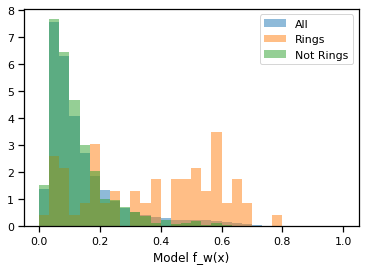

In [73]:
_, viz_bins = np.histogram(np.linspace(0, 1), bins=30)
plt.hist(random_preds, density=True, alpha=.5, label='All', bins=viz_bins)
plt.hist(random_expert_ring_preds, density=True, alpha=.5, label='Rings', bins=viz_bins)
plt.hist(random_expert_not_ring_preds, density=True, alpha=.5, label='Not Rings', bins=viz_bins)
# should be same as they are all random
plt.xlabel('Model f_w(x)')
plt.legend()

In [74]:
p_ring = vote_df['is_ring'].mean()
p_ring

0.053334965217185316

In [83]:
# _, bins = np.histogram(np.linspace(0., 1.), bins=10)  # uniform bins aren't great for very peaky classifier
num_bins = 5
percentiles = [n * (100/num_bins) for n in range(0, num_bins+1)]
percentiles
# 11 percentiles, forming 10 bins

[0.0, 20.0, 40.0, 60.0, 80.0, 100.0]

In [84]:
percentile_values = np.percentile(random_preds, percentiles)  # percentiles of all predictions
percentile_values

array([4.71472740e-04, 5.47260344e-02, 8.06896687e-02, 1.20601445e-01,
       2.00559080e-01, 7.88390994e-01])

In [85]:
# # bins = [(low_p, high_p) for (low_p, high_p) in zip(percentiles[:-1], percentiles[1:])]
# 
# bins

In [86]:
# center_of_imaginary_right_bin = percentile_values[-1] + (1. - percentile_values[-1])/2
# bins = np.concatenate([percentile_values, [center_of_imaginary_right_bin]]) 
# bins

bins = np.array([(low_p, high_p) for (low_p, high_p) in zip(percentile_values[:-1], percentile_values[1:])])
bin_centers = np.array([low_p + ((high_p - low_p)/2) for (low_p, high_p) in zip(percentile_values[:-1], percentile_values[1:])])
bin_centers

array([0.02759875, 0.06770785, 0.10064556, 0.16058026, 0.49447504])

In [87]:
assert (random_expert_ring_preds <= percentile_values.max()).all()  # else counter will put the maximal values outside the rightmost bin, at index 11 

In [88]:
def get_percentile_histogram(x, percentiles):
    # digitize gives index such that x is between bins[i-1] < x < bins[i]
    # values outside the range snap to the closest bin (i.e. 0 or len(bins))
    bin_of_each_x = np.digitize(x, percentiles)
    x_per_bin_counter = Counter(bin_of_each_x)
#     rings_per_bin_counter  # will have indices from 1 to 11 (as x == min bin gives 1, not 0)
    assert x_per_bin_counter[len(percentiles)+1] == 0
    
    x_per_bin = np.zeros(len(bins))  # 10 
    for bin_index in range(len(bins)): # 0 to 10
        x_per_bin[bin_index] = x_per_bin_counter[bin_index+1]  # indexed via 1 to 11
    return x_per_bin  # counts of values from percentile[i] to percentile[i+1]. Will be one less then len(percentiles)

In [89]:
rings_per_bin = get_percentile_histogram(random_expert_ring_preds.squeeze(), percentile_values)
rings_per_bin

array([ 5.,  5.,  3.,  9., 47.])

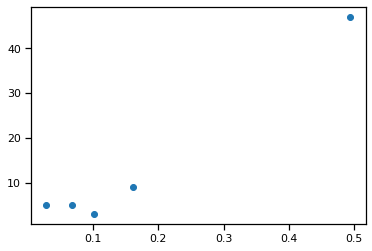

In [90]:
plt.scatter(bin_centers, rings_per_bin)

In [91]:
assert len(random_expert_ring_preds) == rings_per_bin.sum()

In [92]:
rings_per_bin

array([ 5.,  5.,  3.,  9., 47.])

In [93]:
ring_rates = rings_per_bin / len(expert_labelled_rings)
ring_rates

array([0.07246377, 0.07246377, 0.04347826, 0.13043478, 0.68115942])

In [94]:


def empirical_prob_from_histogram(values_to_query, rates, bin_edges):
    bin_edges = bin_edges.copy()
    bin_edges[-1]= bin_edges[-1]+1e-8  # if values_to_query includes exactly the max bin edge
    # rates from 0 to 10, corresponding to frequencies between each (0-11) bin edge 
    assert all(values_to_query <= bin_edges.max())  # no rate above the highest bin edge, bins must cover whole range
    bin_indices = np.digitize(values_to_query, bin_edges)  # should be 10 indices
#     print(bin_indices.min(), bin_indices.max())
    return np.array([rates[bin_index-1] for bin_index in bin_indices])


In [95]:
p_output_given_ring = empirical_prob_from_histogram(random_preds.squeeze(), ring_rates, percentile_values)

In [96]:
p_output_given_ring

array([0.68115942, 0.04347826, 0.07246377, ..., 0.04347826, 0.04347826,
       0.07246377])

In [97]:
pd.value_counts(p_output_given_ring.squeeze()).sort_index(ascending=False)

0.681159     50658
0.130435     50657
0.072464    101314
0.043478     50657
dtype: int64

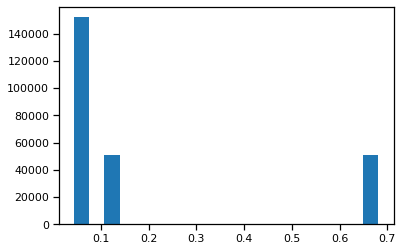

In [98]:
_ = plt.hist(p_output_given_ring, bins=20)

In [99]:
# p(ring|f(x)) = p(f(x)|ring)p(ring)/ [ p(f(x)|ring)p(ring) + p(f(x)|p(~ring))p(~ring)]

In [100]:
p_not_ring = 1 - p_ring

In [101]:
not_rings_per_bin = get_percentile_histogram(random_expert_not_ring_preds.squeeze(), percentile_values)
not_rings_per_bin  # roughly equal, but fewer at the top

array([189., 197., 201., 203., 141.])

In [102]:
not_ring_rates = not_rings_per_bin / len(random_expert_not_ring_preds)
not_ring_rates

array([0.20300752, 0.21160043, 0.21589689, 0.21804511, 0.15145005])

In [103]:
p_output_given_not_ring = empirical_prob_from_histogram(random_preds.squeeze(), not_ring_rates, percentile_values)

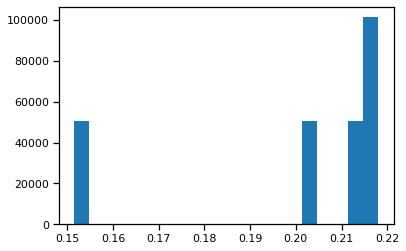

In [104]:
_ = plt.hist(p_output_given_not_ring, bins=20)

In [105]:
p_ring_given_output = p_output_given_ring * p_ring / (p_output_given_ring * p_ring + p_output_given_not_ring * p_not_ring)

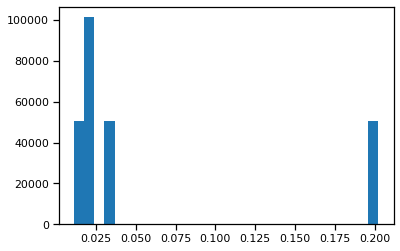

In [106]:
_ = plt.hist(p_ring_given_output, bins=30)  # can I use this alone? p output given not ring is much easier to calculate, perhaps?

In [107]:
# pd.value_counts(p_ring_given_output)

In [108]:
vote_df['p_ring_given_output'] = p_ring_given_output

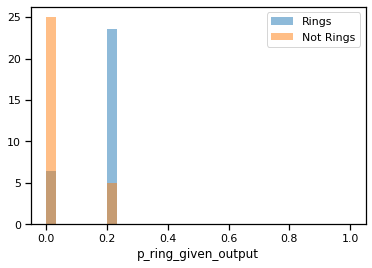

In [109]:
_, viz_bins = np.histogram(np.linspace(0, 1), bins=30)
# plt.hist(vote_df, density=True, alpha=.5, label='All', bins=viz_bins)
plt.hist(vote_df.query('is_ring')['p_ring_given_output'], density=True, alpha=.5, label='Rings', bins=viz_bins)
plt.hist(vote_df[~vote_df['is_ring']]['p_ring_given_output'], density=True, alpha=.5, label='Not Rings', bins=viz_bins)
# should be same as they are all random
plt.xlabel('p_ring_given_output')
plt.legend()

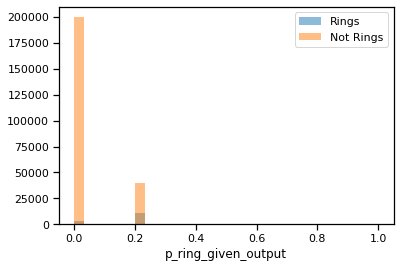

In [110]:
_, viz_bins = np.histogram(np.linspace(0, 1), bins=30)
# plt.hist(vote_df, density=True, alpha=.5, label='All', bins=viz_bins)
plt.hist(vote_df.query('is_ring')['p_ring_given_output'], alpha=.5, label='Rings', bins=viz_bins)
plt.hist(vote_df[~vote_df['is_ring']]['p_ring_given_output'], alpha=.5, label='Not Rings', bins=viz_bins)
# should be same as they are all random
plt.xlabel('p_ring_given_output')
plt.legend()

In [111]:
likely_ring = vote_df['p_ring_given_output'] > 0.2
is_ring = vote_df['is_ring']

vote_df[likely_ring]['is_ring'].mean()

0.20979904457341386

In [112]:
# Test twice? i.e. then have volunteers verify